In [1]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, TFBertForSequenceClassification
# import tensorflow as tf
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Zychia\AppData\Local\anaconda3\envs\FYP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.cuda.is_available())

True


In [3]:
def convertDataloader(sentences, labels, shuffle):
    # Tokenize the sentences using the BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    encoded = tokenizer(list(sentences), padding=True, truncation=True, return_tensors='pt')
    
    # Create DataLoader
    dataset = TensorDataset(encoded['input_ids'], torch.tensor(labels))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=shuffle)

    return dataloader

In [5]:
def trainModel(model, train_dataloader, num_epochs=20, learning_rate=2e-5):

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    training_loss_values = []

    for epoch in range(num_epochs):
        model.train()
        total_training_loss = 0.0
        
        for batch in train_dataloader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_training_loss += loss.item()

        avg_training_loss = total_training_loss / len(train_dataloader)
        training_loss_values.append(avg_training_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Avg. Training Loss: {avg_training_loss}')

    plt.plot(training_loss_values, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.legend()
    plt.show()

In [6]:
def evaluateModel(model, dataloader, labels):
    model.eval()
    predictions = []
    losses = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    with torch.no_grad():
        for batch in dataloader:
            inputs, batch_labels = batch
            inputs, batch_labels = inputs.to(device), batch_labels.to(device)
            outputs = model(inputs, labels=batch_labels) 
            logits = outputs.logits
            
            predictions_batch = torch.argmax(logits, dim=1)
            predictions.extend(predictions_batch.cpu().numpy())
            losses.append(outputs.loss.item())

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro') 
    precision = precision_score(labels, predictions, average='macro') 
    recall = recall_score(labels, predictions, average='macro')
    avg_loss = np.mean(losses)
    conf_matrix = confusion_matrix(labels, predictions)
    
    print(f'Accuracy: {accuracy}')
    print(f'F1 Score: {f1}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'Average Loss: {avg_loss}')
    print('Confusion Matrix:')
    print(conf_matrix)

In [10]:
# csv_path = 'CsvFile/'
csv_path = 'NewDatasets4.0/'
# csv_path = 'Filter Datasets/'
# df = pd.read_csv(csv_path+'memd_book.csv')
# df3 = pd.read_csv(csv_path+'memd_hotel.csv')
# df1 = pd.read_csv(csv_path+'memd_clothing.csv')
# df2 = pd.read_csv(csv_path+'memd_laptop.csv')
# df4 = pd.read_csv(csv_path+'memd_restaurant.csv')

df = pd.read_csv('opinion_driven_labelling.csv')

# merged_df = pd.concat([df, df1,df2,df3,df4], axis=0, ignore_index=True)

# sentiment_mapping = {'NEG': 0, 'POS': 1, 'NEU': 2}
# merged_df['sentiment'] = merged_df['sentiment'].map(sentiment_mapping)

# print(merged_df['sentiment'].unique())

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_sentences = train_df['raw_words'].values
train_labels = train_df['subjectivity'].values

test_sentences = test_df['raw_words'].values
test_labels = test_df['subjectivity'].values

# merged_df.to_csv('opinion_driven_labelling.csv', index=False)

In [11]:
# print(merged_df['subjectivity'].value_counts())
print(train_df['subjectivity'].value_counts())
print(test_df['subjectivity'].value_counts())

# print(df['subjectivity'].value_counts())
# print(df1['subjectivity'].value_counts())

subjectivity
0    12148
1     1904
Name: count, dtype: int64
subjectivity
0    3029
1     485
Name: count, dtype: int64


In [12]:
train_dataloader = convertDataloader(train_sentences, train_labels, shuffle=True)
test_dataloader = convertDataloader(test_sentences, test_labels, shuffle=False)


In [13]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


C:\Users\Zychia\AppData\Local\anaconda3\envs\FYP\Lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 1/20, Avg. Training Loss: 0.29800453121689235
Epoch 2/20, Avg. Training Loss: 0.18139545898884535
Epoch 3/20, Avg. Training Loss: 0.13029662404548037
Epoch 4/20, Avg. Training Loss: 0.08234838334504854
Epoch 5/20, Avg. Training Loss: 0.04874667844481089
Epoch 6/20, Avg. Training Loss: 0.03339725271904503
Epoch 7/20, Avg. Training Loss: 0.021500551818594844
Epoch 8/20, Avg. Training Loss: 0.016078277430708773
Epoch 9/20, Avg. Training Loss: 0.016831761319454845
Epoch 10/20, Avg. Training Loss: 0.013358756858029995
Epoch 11/20, Avg. Training Loss: 0.0115682453480655
Epoch 12/20, Avg. Training Loss: 0.011537715045745823
Epoch 13/20, Avg. Training Loss: 0.0062960597728140945
Epoch 14/20, Avg. Training Loss: 0.01319355073593959
Epoch 15/20, Avg. Training Loss: 0.006552757904864847
Epoch 16/20, Avg. Training Loss: 0.006278734578782777
Epoch 17/20, Avg. Training Loss: 0.0025231919959465316
Epoch 18/20, Avg. Training Loss: 0.006397540454881064
Epoch 19/20, Avg. Training Loss: 0.007410676

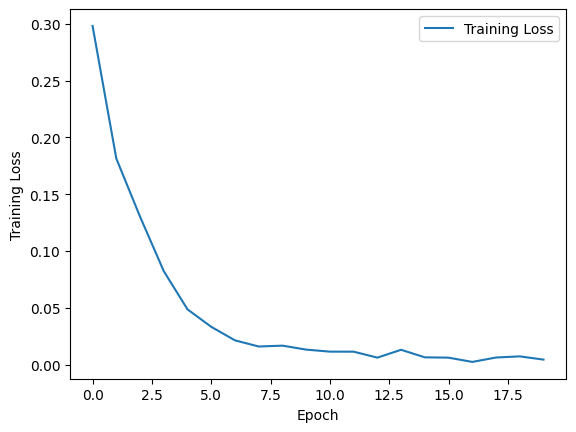

In [14]:
trainModel(model, train_dataloader)


In [15]:
evaluateModel(model, test_dataloader, test_labels)

Accuracy: 0.937677859988617
F1 Score: 0.8550665026676212
Precision: 0.9007304083099412
Recall: 0.8218489311228571
Average Loss: 0.41571612302743066
Confusion Matrix:
[[2974   55]
 [ 164  321]]
